Importing Libraries


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()

Loading Dataset

In [ ]:
df =pd.read_csv('/content/twitter_training.csv')


In [ ]:
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
np.unique(df['Borderlands'])

array(['Amazon', 'Borderlands', 'CallOfDutyBlackopsColdWar', 'Dota2',
       'NBA2K', 'Overwatch', 'Xbox(Xseries)'], dtype=object)

In [ ]:
np.unique(df['Positive'])

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
df = df.drop('2401' , axis=1)

In [ ]:
df= df.rename(columns={"Borderlands":"Feature2","im getting on borderlands and i will murder you all ,":"Feature1","Positive": "labels"})

In [ ]:
df.head()

,Feature2,labels,Feature1
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)


In [ ]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels


{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [ ]:
def getlabel(n) :
    for x , y in df_labels.items() :
        if y==n :
            return x

EDA

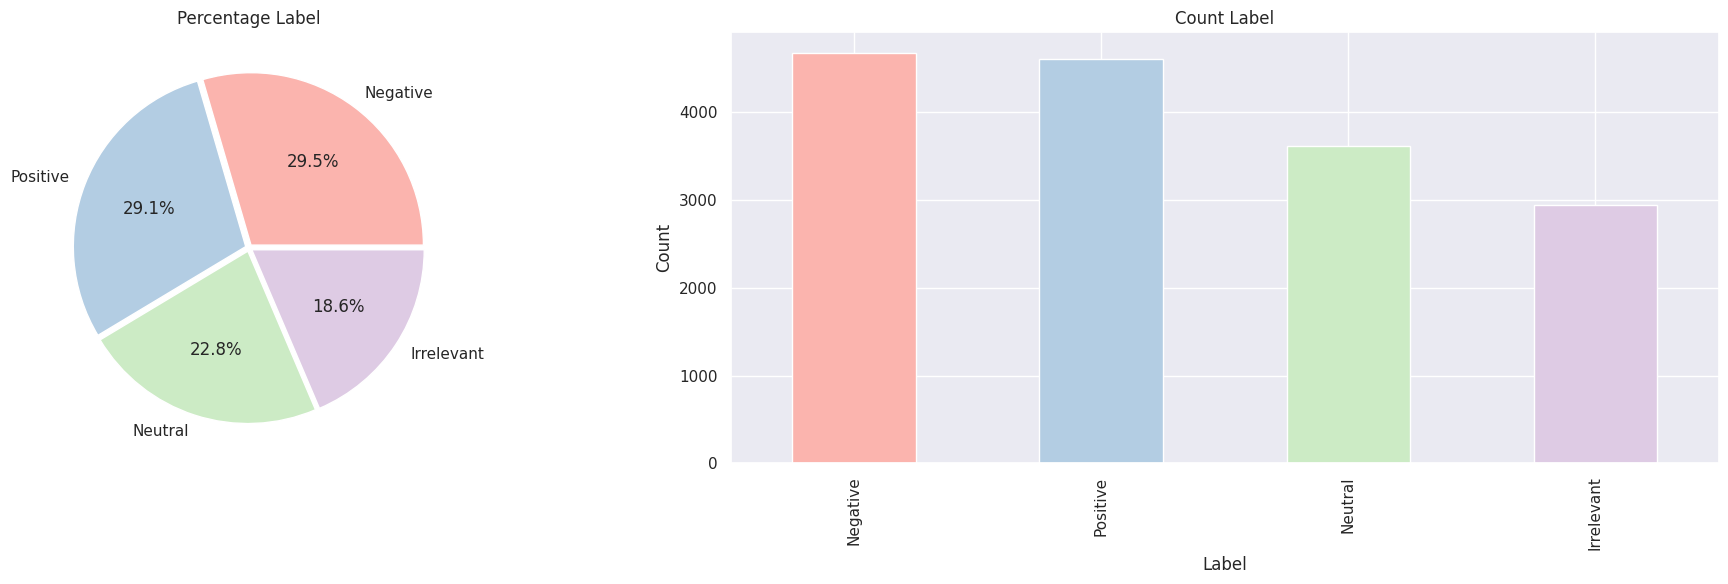

In [ ]:
label_count = df['labels'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

colors = plt.get_cmap('Pastel1').colors
explode = [0.02] * len(label_count)

# Pie chart
axes[0].pie(label_count, labels=label_count.index, autopct='%1.1f%%', colors=colors, explode=explode)
axes[0].set_title('Percentage Label')

# Count plot
label_count.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()



In [ ]:
def Most_Words_used(tweets , num_of_words) :
    all_text = ''.join(df[tweets].values)

    all_text = re.sub('<.*?>', '', all_text) # HTML tags
    all_text = re.sub(r'\d+', '', all_text) # numbers
    all_text = re.sub(r'[^\w\s]', '', all_text) # special characters
    all_text = re.sub(r'http\S+', '', all_text) # URLs or web links
    all_text = re.sub(r'@\S+', '', all_text) # mentions
    all_text = re.sub(r'#\S+', '', all_text) # hashtags

    words = all_text.split()

    # remove puncs
    punc = list(punctuation)
    words = [word for word in words if word not in punc]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    word_counts = Counter(words)

    top_words = word_counts.most_common(num_of_words)

    return top_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


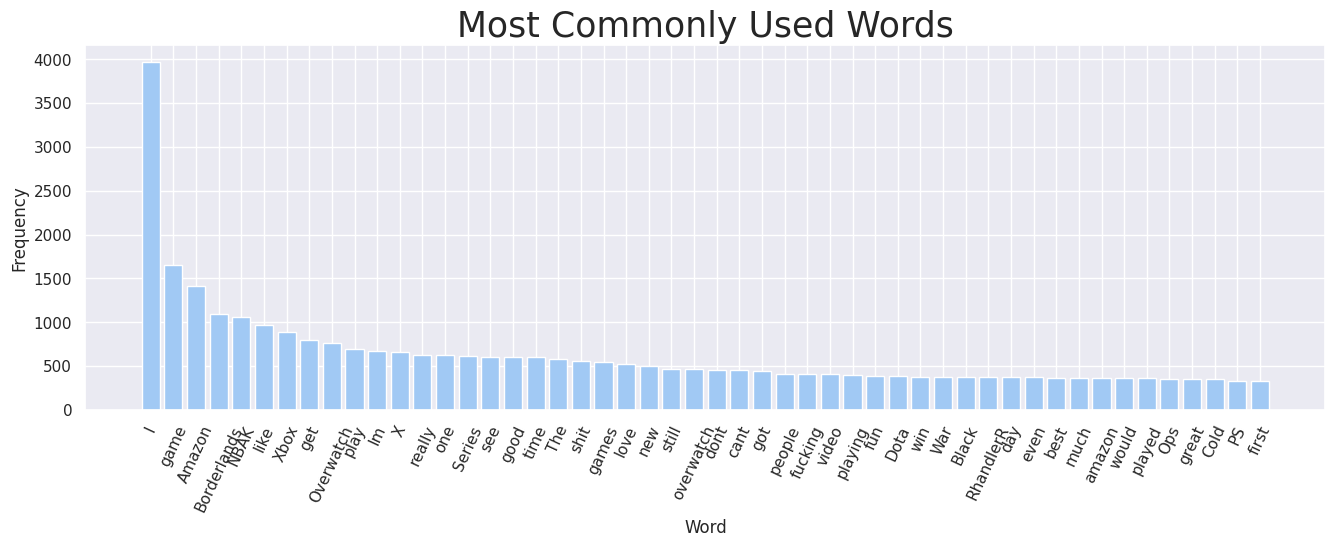

In [ ]:
import nltk
nltk.download('stopwords')
top_words = Most_Words_used('tweets' , 50)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=65)
plt.subplots_adjust(bottom=0.15)
plt.show()

Data Preprocessing

In [ ]:
def DataPrep(text) :
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    text = re.sub(r'http\S+', '', text) # URLs or web links
    text = re.sub(r'@\S+', '', text) # mentions
    text = re.sub(r'#\S+', '', text) # hashtags

    # tokenization
    tokens = nltk.word_tokenize(text)

    # remove puncs
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word.lower() in stop_words]

    # Lemmatization
    words = [lemma.lemmatize(word) for word in words]

    text = ' '.join(words)

    return text

In [ ]:
 import nltk
 nltk.download('punkt')
 nltk.download('wordnet')
 df['cleaned_tweets'] = df['tweets'].apply(DataPrep)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
print(f'There are around {int(df["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 2607 duplicated tweets, we will remove them.


In [ ]:
df.drop_duplicates("cleaned_tweets", inplace=True)

In [ ]:
df['tweet_len'] = [len(text.split()) for text in df.cleaned_tweets]


In [ ]:
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

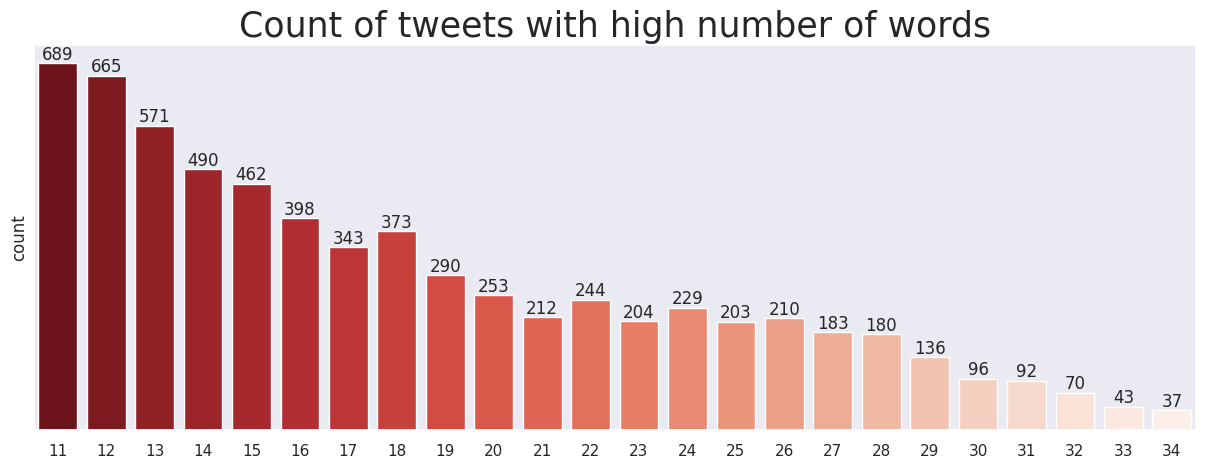

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Reds_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

Split the data

In [ ]:
x_train , x_val , y_train , y_val = train_test_split(df['cleaned_tweets'] , df['labels'] , train_size = 0.85 , random_state=42)


In [ ]:
len(x_train) , len(x_val)

(11168, 1971)

Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
tfidf_matrix = vec.fit_transform(x_train)
feature_names = vec.get_feature_names_out()

print("No. of feature words: ", len(feature_names))

No. of feature words:  11117


In [ ]:
x_train = vec.transform(x_train).toarray()
x_val = vec.transform(x_val).toarray()


Encoding

In [ ]:
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)


Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train , y_train)

LogisticRegression(random_state=42)

In [ ]:
train_acc1 = lr.score(x_train , y_train)


In [ ]:
lr_pred = lr.predict(x_val)

val_acc1 = accuracy_score(y_val , lr_pred)

val_precision1 = precision_score(y_val , lr_pred , average='weighted')
val_recall1 = recall_score(y_val , lr_pred , average='weighted')
val_f1score1 = f1_score(y_val , lr_pred , average='weighted')

In [ ]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The validation accuracy for logistic regression : {(val_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {val_precision1:0.2f}\n")
print(f"The recall for logistic regression : {val_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {val_f1score1:0.2f}\n")

The training accuracy for logistic regression : 93.45%

The validation accuracy for logistic regression : 84.63%

The precision for logistic regression : 0.85

The recall for logistic regression : 0.85

The f1 score for logistic regression : 0.85



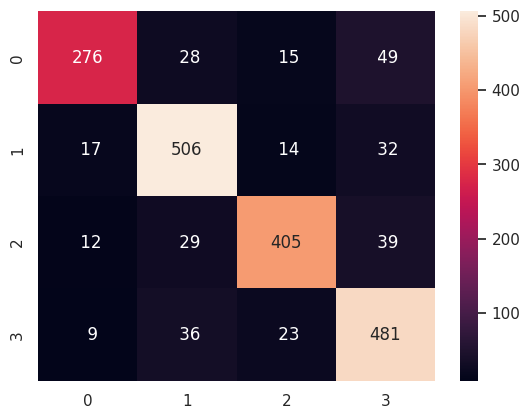

In [ ]:
lr_cm = confusion_matrix(y_val , lr_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(x_train , y_train)

RandomForestClassifier()

In [ ]:
train_acc2 = rf.score(x_train , y_train)

In [ ]:
rf_pred = rf.predict(x_val)

val_acc2 = accuracy_score(y_val , lr_pred)

val_precision2 = precision_score(y_val , rf_pred , average='weighted')
val_recall2 = recall_score(y_val , rf_pred , average='weighted')
val_f1score2 = f1_score(y_val , rf_pred , average='weighted')

In [ ]:
print(f"The training accuracy for Random Forest : {(train_acc2*100):0.2f}%\n")
print(f"The validation accuracy for Random Forest : {(val_acc2*100):0.2f}%\n")
print(f"The precision for Random Forest : {val_precision2:0.2f}\n")
print(f"The recall for Random Forest : {val_recall2:0.2f}\n")
print(f"The f1 score for Random Forest : {val_f1score2:0.2f}\n")

The training accuracy for Random Forest : 99.91%

The validation accuracy for Random Forest : 84.63%

The precision for Random Forest : 0.92

The recall for Random Forest : 0.92

The f1 score for Random Forest : 0.92



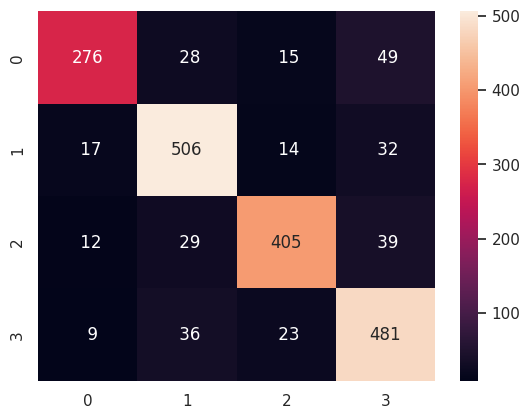

In [ ]:
rf_cm = confusion_matrix(y_val , rf_pred)
sns.heatmap(lr_cm, annot=True,fmt='3g')
plt.show()

LSTM

Data processing for LSTM

In [ ]:
MAX_LEN = np.max(df['tweet_len'])
MAX_LEN


34

In [ ]:
def lstm_prep(column , seq_len) :
    # create a vocab of words
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus)
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}

    text_int = []

    for text in column :
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)


    # padding
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
    for idx , y in tqdm(enumerate(text_int)) :
        if len(y) <= seq_len :
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y

        else :
            new = y[:seq_len]

        features[idx,:] = np.array(new)

    return sorted_words, features

In [ ]:
VOCAB , tokenized_column = lstm_prep(df['cleaned_tweets'] , MAX_LEN)

0it [00:00, ?it/s]

In [ ]:
VOCAB[:10]

[('Amazon', 3279),
 ('Borderlands', 3002),
 ('NBAK', 2900),
 ('Overwatch', 2540),
 ('game', 2040),
 ('XboxXseries', 1903),
 ('CallOfDutyBlackopsColdWar', 1882),
 ('Dota', 1752),
 ('Xbox', 958),
 ('like', 906)]

In [ ]:
len(VOCAB)

14375

In [ ]:
tokenized_column.shape

(13139, 34)

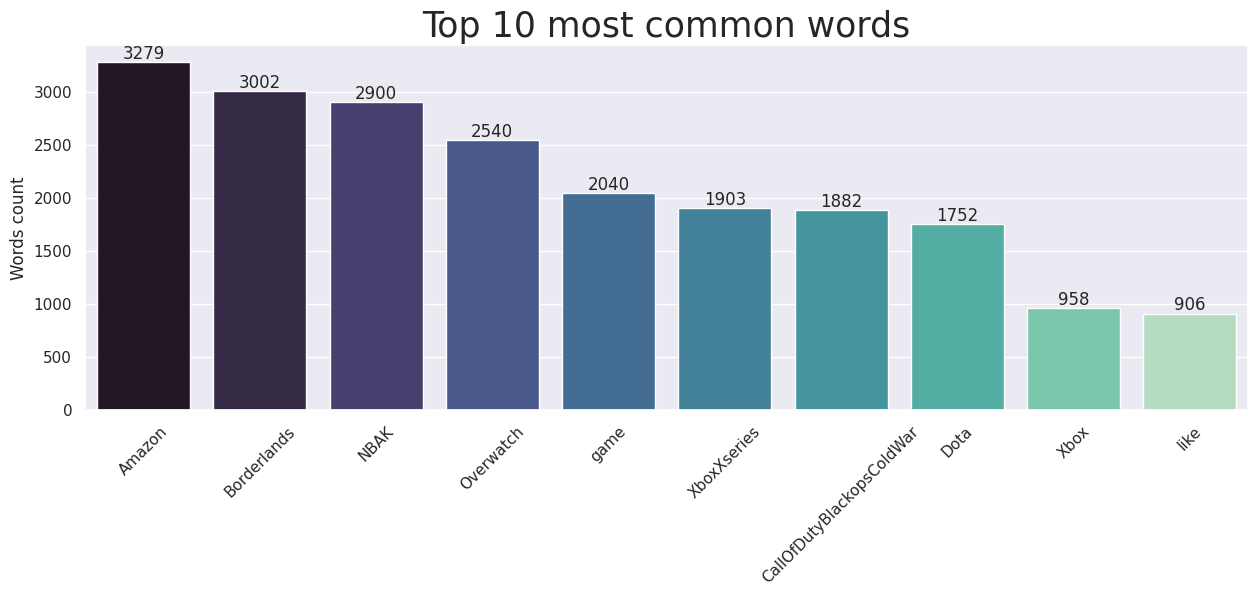

In [ ]:
def most_common_words(vocab):
    keys = []
    values = []
    # Iterating over the list of tuples
    for key, value in vocab[:30]:
        keys.append(key)
        values.append(value)

    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=keys, y=values, palette='mako')
    plt.title('Top 10 most common words', size=25)
    ax.bar_label(ax.containers[0])
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()

most_common_words(VOCAB)

In [ ]:
X = tokenized_column
y = lb.fit_transform(df['labels'].values)

In [ ]:
X_train , X_val , Y_train , Y_val = train_test_split(X , y , train_size=0.85 , random_state=42)


In [ ]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.LongTensor(Y_val))

In [ ]:
BATCH_SIZE = 64


In [ ]:
torch.manual_seed(42)
train_dataloader = DataLoader(
    dataset = train_data ,
    batch_size=BATCH_SIZE ,
    shuffle=True
)


In [ ]:
torch.manual_seed(42)
val_dataloader = DataLoader(
    dataset = val_data ,
    batch_size = BATCH_SIZE ,
    shuffle=False
)

In [ ]:
print(f"the size of the train dataloader {len(train_dataloader)} batches of {BATCH_SIZE}")

the size of the train dataloader 175 batches of 64


In [ ]:
print(f"the size of the validation dataloader {len(val_dataloader)} batches of {BATCH_SIZE}")

the size of the validation dataloader 31 batches of 64


In [ ]:
EMBEDDING_DIM = 200


In [ ]:
Word2vec_train_data = list(map(lambda x: x.split(), df['cleaned_tweets']))

In [ ]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [ ]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    for word, token in vocab:
        if model.wv.__contains__(word):
            embedding_matrix[token]=model.wv.__getitem__(word)
    return embedding_matrix

In [ ]:
embedding_vec = weight_matrix(word2vec_model, VOCAB)
print("Embedding Matrix Shape:", embedding_vec.shape)

IndexError: ignored

In [ ]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [ ]:
class LSTM(nn.Module) :
    def __init__(self , vocab_size , embedding_dim
                 , num_layers , hidden_dim , out_channels , bidirectional) :
        super().__init__()

        self.no_layers = num_layers
        self.hidden_dim = hidden_dim
        self.out_channels = out_channels
        self.num_directions = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size , embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim ,
            hidden_dim ,
            num_layers ,
            dropout = 0.5 ,
            bidirectional = bidirectional ,
            batch_first = True
        )

        self.fc = nn.Linear(hidden_dim*self.num_directions , out_channels)


    def forward(self , x) :
        h0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))
        c0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim))

        embedded = self.embedding(x)

        out , _ = self.lstm(embedded , (h0 , c0))

        out = out[:,-1,:]

        out = self.fc(out)

        return out

In [ ]:
# define parameters
VOCAB_SIZE = len(VOCAB) + 1
NUM_LAYERS = 2
OUT_CHANNELS = 4
HIDDEN_DIM = 256
BIDIRECTIONAL = True

model = LSTM(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL)


model.embedding.weight.requires_grad = True

In [ ]:
param_count(model)

The Total number of parameters in the model :  2519196


In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)

In [ ]:
import numpy as np

epochs = 10
training_loss = []
training_acc = []

for i in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_acc = 0

    for batch, (x_train, y_train) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(x_train)

        loss = criterion(y_pred, y_train)

        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Accumulate the scalar value of the loss
        epoch_acc += accuracy_score(y_train.numpy(), y_pred.argmax(dim=1).detach().numpy())

    # Append values after the inner loop
    training_loss.append(epoch_loss / len(train_dataloader))
    training_acc.append(epoch_acc / len(train_dataloader))

    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")


  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: ignored

In [ ]:
import numpy as np

epochs = 10
training_loss = []
training_acc = []

for i in tqdm(range(epochs)):
    epoch_loss = 0
    epoch_acc = 0

    for batch, (x_train, y_train) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y_pred = model(x_train)

        loss = criterion(y_pred, y_train)

        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # Use loss.item() to get the scalar value of the loss
        # Compute accuracy
        _, predicted = torch.max(y_pred, 1)
        epoch_acc += (predicted == y_train).sum().item() / y_train.size(0)

    training_loss.append(epoch_loss / len(train_dataloader))
    training_acc.append(epoch_acc / len(train_dataloader))

    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")


  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: ignored